# Test Notebook zur Erstellung von Universal Adversarial Perturbations

Paper: https://arxiv.org/pdf/1610.08401.pdf

Algorithmus:  
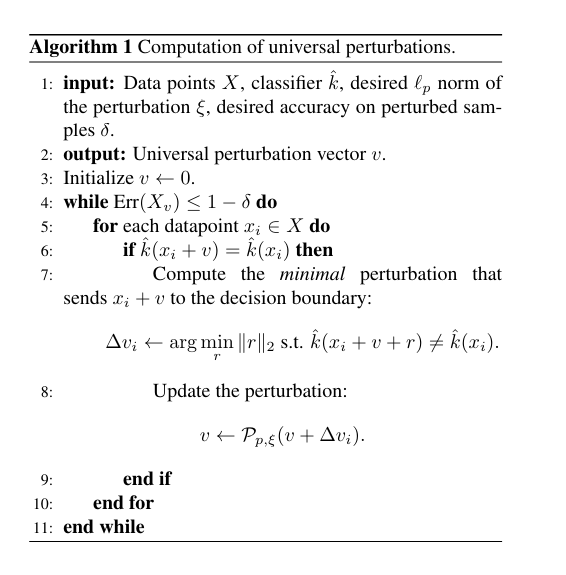

## Settings

In [1]:
%load_ext autoreload
%autoreload 2

import os 
os.chdir("../../main")

import wandb
import torch
import torchvision
import numpy as np
from src.models.imageclassifier import ImageClassifier
from src.data.mri import MRIDataModule

print(f"Working directory: {os.getcwd()}")

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224), antialias=True),
    ]
)

Working directory: c:\Users\Ben\Documents\GitHub\fhnw-bat\main


In [2]:
ENTITY = "24FS_I4DS27"
PROJECT = "baselines"

MODEL_ID = "wlp2yq0j"
MODEL_NAME = "resnet18"
DATASET = "mri-data"

BATCH_SIZE = 32
NUM_WORKERS = 0
P_DROPOUT_CLASSIFIER = 0
LR = 0.00001	
WEIGHT_DECAY = 0

## Get Pretrained Model

In [3]:

model_artifact = wandb.Api().artifact(f"{ENTITY}/{PROJECT}/model-{MODEL_ID}:best", type="model")
model_folder_path = f"models/{MODEL_NAME}-{DATASET}/"
model_path = model_artifact.file(root=model_folder_path)

datamodule = MRIDataModule(
    path="data/raw/Brain-Tumor-MRI",
    path_processed="data/processed/Brain-Tumor-MRI",
    transform=transform,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE,
    train_shuffle=True,
).setup()

model = ImageClassifier.load_from_checkpoint(
    checkpoint_path=model_path,
    modelname=MODEL_NAME,
    output_size=1,
    p_dropout_classifier=P_DROPOUT_CLASSIFIER,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)



## Algorithmus

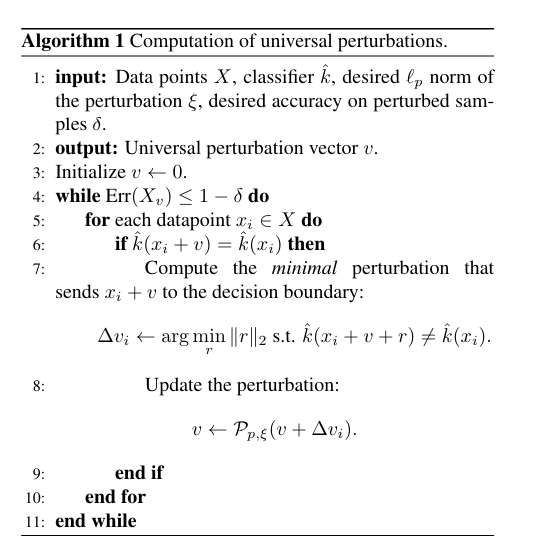

In [4]:
def image_projection_perturbation(norm, datapoints, perturbation):
    if norm == 2:
        perturbation = perturbation * min(1, datapoints / np.linalg.norm(perturbation.flatten(1)))
    elif norm == np.inf:
        perturbation = np.sign(perturbation) * np.minimum(np.abs(perturbation), datapoints)
    return perturbation



In [5]:
perturbation_test = torch.randn(1, 3, 224, 224)
print(f"Dimension of random perturbation", perturbation_test.shape)

datapoints_random = torch.randn(1, 3, 224, 224)
print(f"Dimension of random datapoints", datapoints_random.shape)

# Try to understand step by step what is happening in the image_projection_perturbation function
print(perturbation_test.flatten(1).shape)  # Flattening the 3D Tensor to 1D Tensor

print(np.linalg.norm(perturbation_test.flatten(1), ord=None, axis=None, keepdims=False))  # Calculating the norm of the perturbation 
# Is also called the L2 norm of the perturbation, which is the Euclidean distance between the datapoints and the perturbation 
# also called as Frobenius norm - Check Frobenius Norm Testing 

divison = datapoints_random / np.linalg.norm(perturbation_test.flatten(1))  # Dividing the datapoints by the norm of the perturbation
print(divison.shape) # divide the datapoints by the norm of the perturbation




Dimension of random perturbation torch.Size([1, 3, 224, 224])
Dimension of random datapoints torch.Size([1, 3, 224, 224])
torch.Size([1, 150528])
388.29636
torch.Size([1, 3, 224, 224])


## Frobeniusnorm Testing

In [6]:
# here the calculations by hand are done to understand the function for a 3x3x3 tensor
norm_tensor = torch.randn(1, 3, 3, 3)
print(norm_tensor)
norm_tensor_1d = norm_tensor.flatten(1)
print(norm_tensor_1d)

print(np.linalg.norm(norm_tensor_1d, ord=None, axis=None, keepdims=False))

norm = torch.sqrt(torch.sum(torch.abs(norm_tensor_1d) ** 2, dim=1)) 
print(norm)

tensor([[[[-0.0097,  1.6919, -0.1862],
          [ 0.5000,  0.0266,  0.3664],
          [ 0.0488, -0.2174,  0.5497]],

         [[ 0.2236, -0.2433,  0.2257],
          [ 1.0991,  0.2380,  1.2908],
          [-0.6927, -0.4835, -0.2304]],

         [[ 0.0518,  0.2162, -0.1096],
          [-0.4231, -0.3038,  0.5354],
          [ 0.3890,  1.5678,  0.2935]]]])
tensor([[-0.0097,  1.6919, -0.1862,  0.5000,  0.0266,  0.3664,  0.0488, -0.2174,
          0.5497,  0.2236, -0.2433,  0.2257,  1.0991,  0.2380,  1.2908, -0.6927,
         -0.4835, -0.2304,  0.0518,  0.2162, -0.1096, -0.4231, -0.3038,  0.5354,
          0.3890,  1.5678,  0.2935]])
3.287352
tensor([3.2874])


## Infitinty Norm Testing


In [7]:
pertub = torch.randn(1, 3, 3, 3)
print(pertub)

print(np.sign(pertub))  # The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.

print("test\n", np.minimum(torch.abs(pertub), norm_tensor))  # Element-wise minimum of tensor elements.
print("abssolute Perturbation\n", torch.abs(pertub))
print("Random Tensor\n", norm_tensor)
print("Check elemtnwise if abs is smaller than rand\n", torch.abs(pertub) < norm_tensor)


print(np.sign(pertub) * np.minimum(np.abs(pertub), norm_tensor))

tensor([[[[ 1.4390,  1.3553, -0.8522],
          [ 2.2718,  0.5043, -1.7122],
          [-0.6179, -0.2676,  1.4776]],

         [[ 1.2287,  0.5962, -0.0409],
          [-0.5143, -2.1962, -0.7244],
          [-0.0038, -2.6782, -0.0517]],

         [[ 1.5960, -1.0889,  1.6446],
          [-2.1625, -1.6275, -1.8691],
          [ 0.6856, -0.2151, -0.8966]]]])
tensor([[[[ 1.,  1., -1.],
          [ 1.,  1., -1.],
          [-1., -1.,  1.]],

         [[ 1.,  1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.]],

         [[ 1., -1.,  1.],
          [-1., -1., -1.],
          [ 1., -1., -1.]]]])
test
 tensor([[[[-0.0097,  1.3553, -0.1862],
          [ 0.5000,  0.0266,  0.3664],
          [ 0.0488, -0.2174,  0.5497]],

         [[ 0.2236, -0.2433,  0.0409],
          [ 0.5143,  0.2380,  0.7244],
          [-0.6927, -0.4835, -0.2304]],

         [[ 0.0518,  0.2162, -0.1096],
          [-0.4231, -0.3038,  0.5354],
          [ 0.3890,  0.2151,  0.2935]]]])
abssolute Perturbation
 tens